# Transfer Learning
## Imports and Version Selection


In [1]:
# TensorFlow ≥2.0 is required for this notebook
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# check if GPU is available as this notebook will be very slow without GPU
if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

!pip install --upgrade deeplearning2020
from deeplearning2020 import helpers

# jupyters magic command
%matplotlib inline

Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.21)


In [0]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    # run Xceptions preprocessing function
    preprocessed_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return preprocessed_image, label

## Loading and Preprocessing

/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


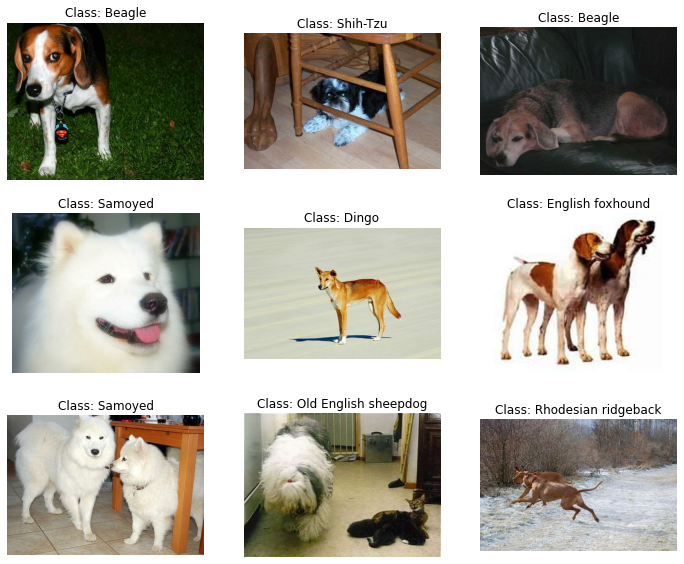

In [10]:
from deeplearning2020.datasets import ImageWoof
train_data, test_data, classes = ImageWoof.load_data()

dataset_size = train_data.element_spec.count
class_names = classes
n_classes = len(classes)

batch_size = 32

train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)
test_data = test_data.map(preprocess).batch(batch_size).prefetch(1) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


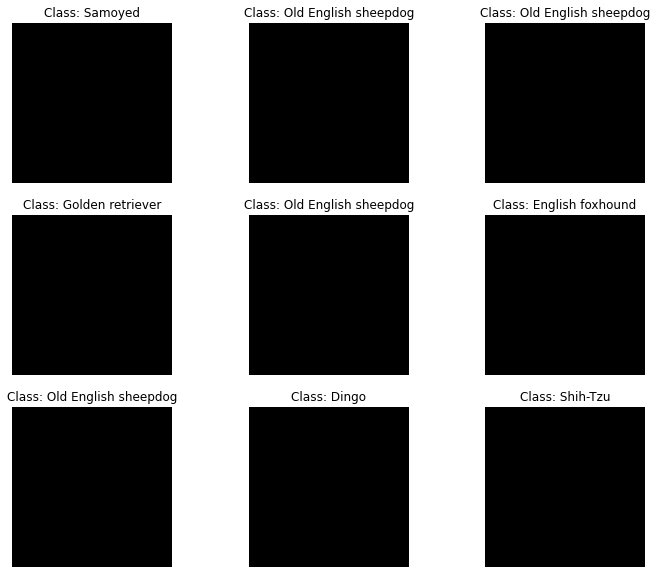

In [9]:
# show some images from the dataset
helpers.plot_images(train_data.unbatch().take(9), class_names)

## Definition and Training

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model = Xception(
    weights='imagenet',
    include_top=False
)
model = GlobalAveragePooling2D()(base_model.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)

83689472/83683744 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
# set the pretrained layers to not trainable because
# there are already trained and we don't want to destroy
# their weights
for layer in base_model.layers:
  layer.trainable = False

![picture](https://drive.google.com/uc?id=1HZoeZaJTuxfBgRIa-iXSmblVqav_5tQ-)

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_data,
    epochs=5,
    validation_data=test_data
)

Epoch 1/5
283/283 [==============================] - 129s 454ms/step - loss: 2.7062 - accuracy: 0.0993 - val_loss: 2.3958 - val_accuracy: 0.1038
Epoch 2/5
 39/283 [===>..........................] - ETA: 1:14 - loss: 2.6303 - accuracy: 0.1202

![picture](https://drive.google.com/uc?id=1PvelbcVzJ9aEuq79C5njvx71MDBnmKyo)

In [0]:
# to finetune the model, we have to set more layers to trainable
# and reduce the learning rate drastically to prevent
# destroying of weights
for layer in base_model.layers:
  layer.trainable = True

In [0]:
# reduce the learning rate to not damage the pretrained weights
# model will need longer to train because all the layers are trainable
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune=model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
92/92 [==============================] - 36s 387ms/step - loss: 0.1017 - accuracy: 0.9721 - val_loss: 0.2701 - val_accuracy: 0.9074
Epoch 2/10
92/92 [==============================] - 35s 378ms/step - loss: 0.0685 - accuracy: 0.9775 - val_loss: 0.2804 - val_accuracy: 0.9087
Epoch 3/10
92/92 [==============================] - 35s 378ms/step - loss: 0.0692 - accuracy: 0.9802 - val_loss: 0.2713 - val_accuracy: 0.9237
Epoch 4/10
92/92 [==============================] - 35s 379ms/step - loss: 0.0410 - accuracy: 0.9871 - val_loss: 0.2789 - val_accuracy: 0.9155
Epoch 5/10
92/92 [==============================] - 35s 378ms/step - loss: 0.0388 - accuracy: 0.9901 - val_loss: 0.2774 - val_accuracy: 0.9183
Epoch 6/10
92/92 [==============================] - 35s 379ms/step - loss: 0.0281 - accuracy: 0.9928 - val_loss: 0.2995 - val_accuracy: 0.9128
Epoch 7/10
92/92 [==============================] - 35s 379ms/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 0.3086 - val_accuracy: 0.9196

## Visualization and Evaluation

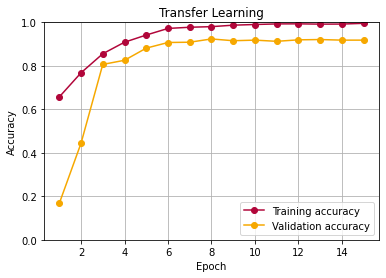

In [0]:
# add the two histories and print the diagram
helpers.plot_two_histories(history, history_finetune)

# Transfer Learning with Data Augmentation
## Model Definition

In [0]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model_data_augmentation = Xception(
    weights='imagenet',
    include_top=False
)
model = GlobalAveragePooling2D()(base_model_data_augmentation.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
data_augmentation_model = Model(base_model_data_augmentation.input, output_layer)

## Adjust Data Augmentation

In [0]:
# resize the images to a uniform size
def preprocess_with_data_augmentation(image, label):
  resized_image = tf.image.resize(image, [224, 224])

  # data augmentation with Tensorflow
  augmented_image = tf.image.random_flip_left_right(resized_image)
  augmented_image = tf.image.random_hue(augmented_image, 0.08)
  augmented_image = tf.image.random_saturation(augmented_image, 0.6, 1.6)
  augmented_image = tf.image.random_brightness(augmented_image, 0.05)
  augmented_image = tf.image.random_contrast(augmented_image, 0.7, 1.3)

  # run Xceptions preprocessing function
  preprocessed_image = tf.keras.applications.xception.preprocess_input(augmented_image)
  return preprocessed_image, label

In [0]:
batch_size = 32
try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True) 
augmented_train_data = train_data.map(preprocess_with_data_augmentation).batch(batch_size).prefetch(1)

## Training

In [0]:
# set the pretrained layers to not trainable because
# there are already trained and we don't want to destroy
# their weights
for layer in base_model_data_augmentation.layers:
  layer.trainable = False
data_augmentation_model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_data_augmentation = data_augmentation_model.fit(
    augmented_train_data,
    epochs=3,
    validation_data=test_data
)

Epoch 1/3
92/92 [==============================] - 13s 137ms/step - loss: 2.4155 - accuracy: 0.7520 - val_loss: 0.7927 - val_accuracy: 0.8828
Epoch 2/3
92/92 [==============================] - 12s 128ms/step - loss: 1.6251 - accuracy: 0.8270 - val_loss: 0.9737 - val_accuracy: 0.8760
Epoch 3/3
92/92 [==============================] - 12s 129ms/step - loss: 1.3145 - accuracy: 0.8450 - val_loss: 0.5669 - val_accuracy: 0.8992


## Finetuning

In [0]:
# to finetune the model, we have to set more layers to trainable
# and reduce the learning rate drastically to prevent
# destroying of weights
for layer in base_model_data_augmentation.layers:
  layer.trainable = True
  # reduce the learning rate to not damage the pretrained weights
# model will need longer to train because all the layers are trainable
data_augmentation_model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_finetune_data_augmentation = data_augmentation_model.fit(
    augmented_train_data,
    epochs=30,
    validation_data=test_data
)

Epoch 1/30
92/92 [==============================] - 36s 387ms/step - loss: 0.6197 - accuracy: 0.8205 - val_loss: 0.4202 - val_accuracy: 0.8924
Epoch 2/30
92/92 [==============================] - 35s 379ms/step - loss: 0.1853 - accuracy: 0.9387 - val_loss: 0.2191 - val_accuracy: 0.9264
Epoch 3/30
92/92 [==============================] - 35s 378ms/step - loss: 0.0745 - accuracy: 0.9762 - val_loss: 0.2350 - val_accuracy: 0.9414
Epoch 4/30
92/92 [==============================] - 35s 379ms/step - loss: 0.0346 - accuracy: 0.9877 - val_loss: 0.2229 - val_accuracy: 0.9469
Epoch 5/30
92/92 [==============================] - 35s 379ms/step - loss: 0.0395 - accuracy: 0.9864 - val_loss: 0.3124 - val_accuracy: 0.9387
Epoch 6/30
92/92 [==============================] - 35s 378ms/step - loss: 0.0151 - accuracy: 0.9942 - val_loss: 0.3101 - val_accuracy: 0.9428
Epoch 7/30
92/92 [==============================] - 35s 379ms/step - loss: 0.0153 - accuracy: 0.9949 - val_loss: 0.2850 - val_accuracy: 0.9496

## Visualization

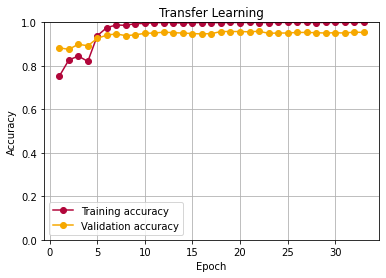

In [0]:
# add the two histories and print the diagram
helpers.plot_two_histories(history_data_augmentation, history_finetune_data_augmentation)